## Getting Started

In [2]:
%matplotlib notebook

import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt

In [3]:
device = 'cuda' if torch.cuda.is_available() else'cpu'
print(device)

cuda


## Data Loader

In [4]:
import socket
import getpass

hostname = socket.gethostname()
username = getpass.getuser()
print(hostname)
print(username)

dataset_root_dir = "/kpuworkshop/birds/"

pod-u8508871
jovyan


In [5]:
class BirdsDataset(td.Dataset):

    def __init__(self, root_dir, mode="train", image_size=(224, 224)):
        super(BirdsDataset, self).__init__()
        self.image_size = image_size
        self.mode = mode
        self.data = pd.read_csv(os.path.join(root_dir, "%s.csv" % mode))
        self.images_dir = os.path.join(root_dir, "CUB_200_2011/images")

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        return "BirdsDataset(mode={}, image_size={})". \
               format(self.mode, self.image_size)

    # Returns image x of index idx together with class label d
    # Crops the image according to the bounding box in the csv file
    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, \
                                self.data.iloc[idx]['file_path'])
        bbox = self.data.iloc[idx][['x1', 'y1', 'x2', 'y2']]
        img = Image.open(img_path).convert('RGB')
        img = img.crop([bbox[0], bbox[1], bbox[2], bbox[3]])
        transform = tv.transforms.Compose([
            tv.transforms.Resize(self.image_size, interpolation=2),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        ])
        x = transform(img)
        d = self.data.iloc[idx]['class']
        return x, d

    def number_of_classes(self):
        return self.data['class'].max() + 1

In [6]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [7]:
# Create object train_set as instance of BirdsDataset
train_set = BirdsDataset(dataset_root_dir)

x,d = train_set[10]

<IPython.core.display.Javascript object>


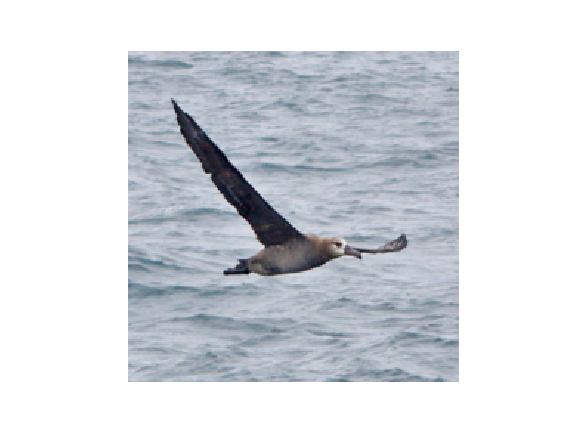

0


In [8]:
# Display image 
myimshow(x)

# Display label
print(d)

In [9]:
# Using PyTorch's Dataset allows use of its data loader mechanism
train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True, pin_memory=True)

In [10]:
# Number of mini-batches
print(len(train_loader))

47


In [11]:
# Display first image and label of first four mini-batches
for k,s in enumerate(train_loader):
    x=s[0][0]
    d=s[1][0]
    plt.figure()
    myimshow(x)
    print(d)
    if k==3:
        break

<IPython.core.display.Javascript object>

tensor(16)


<IPython.core.display.Javascript object>

tensor(13)


<IPython.core.display.Javascript object>

tensor(19)


<IPython.core.display.Javascript object>

tensor(9)


In [12]:
# Create validation dataset

# Instance of BirdDataset with mode = 'val'
val_set = BirdsDataset(dataset_root_dir, mode='val')

# Similar to train_loader but no shuffle
val_loader = torch.utils.data.DataLoader(train_set, batch_size=16, pin_memory=True)

## Abstract Neural Network Model

In [13]:
# Class describes general architecture and functionalities of NN object
import nntools as nt

In [14]:
help(nt.NeuralNetwork)

Help on class NeuralNetwork in module nntools:

class NeuralNetwork(torch.nn.modules.module.Module, abc.ABC)
 |  An abstract class representing a neural network.
 |  
 |  All other neural network should subclass it. All subclasses should override
 |  ``forward``, that makes a prediction for its input argument, and
 |  ``criterion``, that evaluates the fit between a prediction and a desired
 |  output. This class inherits from ``nn.Module`` and overloads the method
 |  ``named_parameters`` such that only parameters that require gradient
 |  computation are returned. Unlike ``nn.Module``, it also provides a property
 |  ``device`` that returns the current device in which the network is stored
 |  (assuming all network parameters are stored on the same device).
 |  
 |  Method resolution order:
 |      NeuralNetwork
 |      torch.nn.modules.module.Module
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(s

In [15]:
net = nt.NeuralNetwork() 

# Error: can't instatiate abstract class NeuralNetwork with abstract methods criterion, forward

TypeError: Can't instantiate abstract class NeuralNetwork with abstract methods criterion, forward

In [16]:
# Define subclass that inherits from NeuralNetwork
# Implements the method criterion as being the cross entropy loss

class NNClassifier(nt.NeuralNetwork):

    def __init__(self):
        super(NNClassifier, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()

    def criterion(self, y, d):
        return self.cross_entropy(y, d)
    
# More specific than NeuralNetwork, but still abstract and doesn't implement the method forward

## VGG-16 Transfer Learning

In [17]:
vgg = tv.models.vgg16_bn(pretrained=True)

In [18]:
print(vgg)

# Return learnable parameters of the modelv
vgg.parameters()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

<generator object Module.parameters at 0x7feb4c713de0>

In [ ]:
# Subclass that inherits from NNClassifier

class VGG16Transfer(NNClassifier):

    def __init__(self, num_classes, fine_tuning=False):
        super(VGG16Transfer, self).__init__()
        vgg = tv.models.vgg16_bn(pretrained=True)
        for param in vgg.parameters():
            param.requires_grad = fine_tuning
        self.features = vgg.features
        # COMPLETE
        num_ftrs = vgg.classifier[6].in_features
        self.classifier[6] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        # COMPLETE
        y = self.classifier(f)
        return y

In [ ]:
numclasses = trainset.numberofclasses()

In [ ]:
print(numclasses)

# Return learnable parameters of the modelv
numclasses.parameters()